# Neural Network for Churn Prediction
* The source was written for kaggle competition
* WSDM - KKBox's Churn Prediction Challenge
* https://www.kaggle.com/c/kkbox-churn-prediction-challenge

In [40]:
from multiprocessing import Pool, cpu_count
import gc; gc.enable()
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.svm import OneClassSVM
import collections

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

## Read Data
#### train.csv - the train set, containing the user ids and whether they have churned.
* msno: user id
* is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.
#### train_v2.csv - same format as train.csv, refreshed 11/06/2017, contains the churn data for March, 2017.

In [2]:
train = pd.read_csv('train.csv')
train = pd.concat((train, pd.read_csv('train_v2.csv')),axis=0, ignore_index=True).reset_index(drop=True)
test = pd.read_csv('sample_submission_v2.csv')

In [3]:
print (collections.Counter(train['is_churn']))

Counter({0L: 1813090, 1L: 150801})


In [4]:
print test.shape
print train.shape

(907471, 2)
(1963891, 2)


#### Transactions of users
##### transactions.csv - transactions of users up until 2/28/2017.
* msno: user id
* payment_method_id: payment method
* payment_plan_days: length of membership plan in days
* plan_list_price: in New Taiwan Dollar (NTD)
* actual_amount_paid: in New Taiwan Dollar (NTD)
* is_auto_renew
* transaction_date: format %Y%m%d
* membership_expire_date: format %Y%m%d
* is_cancel: whether or not the user canceled the membership in this transaction.
##### transactions_v2.csv - same format as transactions.csv, refreshed 11/06/2017, contains the transactions data until 3/31/2017.

#### To begin with, we will use the following features:
* trans_count - numberof user's transactions
* The last transaction detailes.

In [5]:
transactions = pd.read_csv('transactions.csv', usecols=['msno'])
transactions = pd.concat((transactions, pd.read_csv('transactions_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','trans_count']
train = pd.merge(train, transactions, how='left', on='msno')
test = pd.merge(test, transactions, how='left', on='msno')


In [6]:
transactions = pd.read_csv('transactions_v2.csv') 
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')

train = pd.merge(train, transactions, how='left', on='msno')
test = pd.merge(test, transactions, how='left', on='msno')
transactions=[]

### User Logs - daily user logs describing listening behaviors of a user
#### user_logs.csv - Data collected until 2/28/2017.
* msno: user id
* date: format %Y%m%d
* num_25: # of songs played less than 25% of the song length
* num_50: # of songs played between 25% to 50% of the song length
* num_75: # of songs played between 50% to 75% of of the song length
* num_985: # of songs played between 75% to 98.5% of the song length
* num_100: # of songs played over 98.5% of the song length
* num_unq: # of unique songs played
* total_secs: total seconds played
#### user_logs_v2.csv - same format as user_logs.csv, refreshed 11/06/2017, contains the user logs data until 3/31/2017.

#### user_logs.csv is a big file, to big to be contained in memory. so to begin with,we willuse the following fetures:
* Number of user logs
* last user log detailes(from user_logs_v2.csv)
* Thanks to the1owl for thekernel "Regressing During Insomnia [0.21496]" https://www.kaggle.com/the1owl/regressing-during-insomnia-0-21496 for the code to read user logs features. 


In [7]:
user_logs = pd.read_csv('user_logs_v2.csv', usecols=['msno'])
user_logs = pd.DataFrame(user_logs['msno'].value_counts().reset_index())
user_logs.columns = ['msno','logs_count']
train = pd.merge(train, user_logs, how='left', on='msno')
test = pd.merge(test, user_logs, how='left', on='msno')

user_logs = []; 

In [8]:
def transform_df(df):
    df = pd.DataFrame(df)
    df = df.sort_values(by=['date'], ascending=[False])
    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset=['msno'], keep='first')
    return df

def transform_df2(df):
    df = df.sort_values(by=['date'], ascending=[False])
    df = df.reset_index(drop=True)
    df = df.drop_duplicates(subset=['msno'], keep='first')
    return df

In [9]:
last_user_logs = []
last_user_logs.append(transform_df(pd.read_csv('user_logs_v2.csv')))
last_user_logs = pd.concat(last_user_logs, axis=0, ignore_index=True).reset_index(drop=True)
last_user_logs = transform_df2(last_user_logs)

train = pd.merge(train, last_user_logs, how='left', on='msno')
test = pd.merge(test, last_user_logs, how='left', on='msno')

In [10]:
last_user_logs=[]

### Members data - user information
#### members.csv - user information. Note that not every user in the dataset is available.
* msno
* city
* bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
gender
* registered_via: registration method
*registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d, taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.
#### members_v3.csv - Refreshed 11/13/2017, replaces members.csv data with the expiration date data removed.

In [11]:
members = pd.read_csv('members_v3.csv')
train = pd.merge(train, members, how='left', on='msno')
test = pd.merge(test, members, how='left', on='msno')
members = []; print('members merge...') 

members merge...


In [12]:
gender = {'male':1, 'female':2}
train['gender'] = train['gender'].map(gender)
test['gender'] = test['gender'].map(gender)

train = train.fillna(0)
test = test.fillna(0)

In [23]:
train = train.fillna(0)
test = test.fillna(0)
train.head()

,msno,is_churn,trans_count,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,...,num_75,num_985,num_100,num_unq,total_secs,city,bd,gender,registered_via,registration_init_time
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,18.0,36.0,2.0,9.0,20050406.0
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,281.600,10.0,38.0,1.0,9.0,20050407.0
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,11.0,27.0,2.0,9.0,20051016.0
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1,3,40.0,30.0,149.0,149.0,1.0,20170327.0,20170426.0,...,5.0,4.0,19.0,51.0,6171.145,13.0,23.0,2.0,9.0,20051102.0
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1,9,38.0,90.0,477.0,477.0,0.0,20170225.0,20170528.0,...,0.0,2.0,11.0,12.0,3132.042,3.0,27.0,1.0,9.0,20051228.0


In [ ]:
test.to_csv('test_xgb_0.14343.csv', index=False)

In [ ]:
train.to_csv('train_xgb_0.14343.csv', index=False)

# Simple Deep Learning: Feedforward Neural Network

In [19]:
# For Keras
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Lambda
from keras.layers.core import Dropout
from keras import regularizers
from keras.models import Model, load_model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Activation, MaxPooling1D


In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [49]:
def drow_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.title('ROC Curve - Receiver Operating Characteristic')
    plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'g--')
    plt.xlim([-0.001, 1])
    plt.ylim([0, 1.001])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show();

In [32]:
def drow_precision_recal(y_true, y_pred):
    precision, recall, th = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, 'b', label='Precision-Recall curve')
    plt.title('Recall vs Precision')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([-0.01, 0.5])
    plt.show()

In [33]:
def drow_recall(y_true, y_pred):
    precision, recall, th = precision_recall_curve(y_true, y_pred)
    plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
    plt.title('Recall for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Recall')
    plt.show()

In [34]:
def drow_precision(y_true, y_pred):
    precision, recall, th = precision_recall_curve(y_true, y_pred)
    plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
    plt.title('Precision for different threshold values')
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.show()

In [30]:
def drow_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

#### We have a lot of data in the train set, solets splitit totrainand validation set.

In [22]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

XX_train, XX_val = train_test_split(train, test_size=0.2)

In [24]:
cols = [c for c in train.columns if c not in ['is_churn','msno']]

X_train = StandardScaler().fit_transform(XX_train[cols])#.as_matrix()
y_train = XX_train['is_churn'].as_matrix()
X_val = StandardScaler().fit_transform(XX_val[cols])#.as_matrix()
y_val = XX_val['is_churn'].as_matrix()
X_test = StandardScaler().fit_transform(test[cols])#.as_matrix()

In [25]:
lsize = 128

In [26]:
model = Sequential()
model.add(Dense(lsize, input_dim=X_train.shape[1],activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.25))
model.add(Dense(lsize/2, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(rate=0.25))
#model.add(Dense(lsize/4, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(lsize/4,kernel_regularizer=regularizers.l2(0.1), activation='relu'))
model.add(Dropout(rate=0.1))
#model.add(Dense(256,kernel_regularizer=regularizers.l2(0.1), activation='relu'))
#model.add(Dropout(rate=0.1))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3072      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
__________

In [27]:
checkpointer = ModelCheckpoint(filepath="model_churn.h5",
                               verbose=0,
                               save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='acc', factor=0.2,patience=1, min_lr=0.0001)
reduce_val_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.4, patience=1, min_lr=0.0001)
es = EarlyStopping(monitor='loss', patience=3, verbose=1, mode='auto')

callbacks_list = [es, reduce_lr, reduce_val_lr, checkpointer]

# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=1026,#512, 
                    validation_split=0.2, verbose=2,#data=(X_val, y_val)
                    callbacks=callbacks_list)

Train on 1256889 samples, validate on 314223 samples
Epoch 1/10
 - 40s - loss: 0.7318 - acc: 0.9492 - val_loss: 0.1219 - val_acc: 0.9570
Epoch 2/10
 - 39s - loss: 0.1196 - acc: 0.9573 - val_loss: 0.1169 - val_acc: 0.9576
Epoch 3/10
 - 39s - loss: 0.1162 - acc: 0.9577 - val_loss: 0.1251 - val_acc: 0.9498
Epoch 4/10
 - 38s - loss: 0.1146 - acc: 0.9578 - val_loss: 0.1291 - val_acc: 0.9488
Epoch 5/10
 - 39s - loss: 0.1133 - acc: 0.9581 - val_loss: 0.1131 - val_acc: 0.9581
Epoch 6/10
 - 44s - loss: 0.1129 - acc: 0.9582 - val_loss: 0.1127 - val_acc: 0.9580
Epoch 7/10
 - 48s - loss: 0.1125 - acc: 0.9582 - val_loss: 0.1135 - val_acc: 0.9569
Epoch 8/10
 - 49s - loss: 0.1122 - acc: 0.9584 - val_loss: 0.1124 - val_acc: 0.9582
Epoch 9/10
 - 42s - loss: 0.1120 - acc: 0.9584 - val_loss: 0.1121 - val_acc: 0.9581
Epoch 10/10
 - 40s - loss: 0.1120 - acc: 0.9584 - val_loss: 0.1120 - val_acc: 0.9581


['acc', 'loss', 'val_acc', 'val_loss', 'lr']


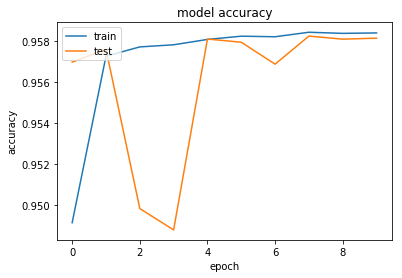

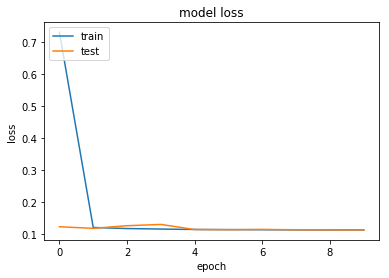

In [41]:
drow_history(history)

In [37]:
predictions = model.predict(X_val)
y_pred = (predictions > 0.5)
print_stats(y_val, y_pred)

Accuracy: 0.95881, Cohen's Kappa Score: 0.69616
Confusion Matrix:
[[355970   6711]
 [  9468  20630]]
Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.98      0.98    362681
          1       0.75      0.69      0.72     30098

avg / total       0.96      0.96      0.96    392779



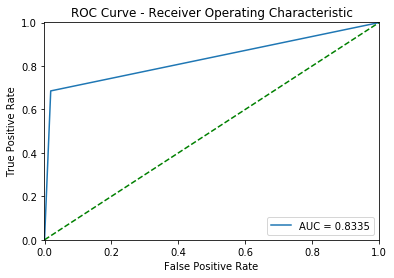

In [50]:
drow_roc_curve(y_val, y_pred)

In [47]:
predictions = model.predict(X_test)

In [48]:
test['is_churn'] = predictions.clip(0.+1e-15, 1-1e-15)
test[['msno','is_churn']].to_csv('submission_NN_std_10epoch.csv', index=False)